In [1]:
#hide
import numpy as np 
from matplotlib import pyplot as plt
import pandas as pd

%matplotlib inline

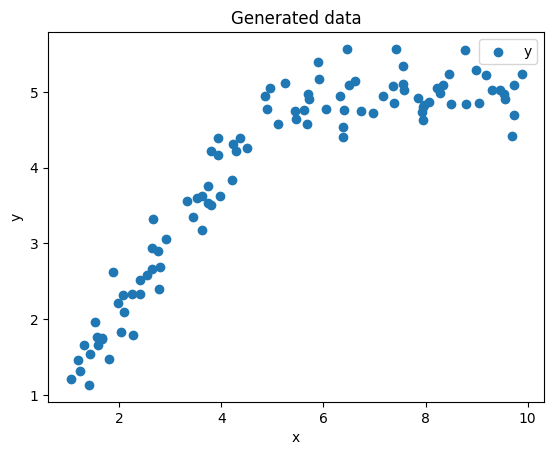

In [2]:
# In this step I will generate some data to test the model toy data 
np.random.seed(42)

# Generate data
x = np.random.uniform(1, 10, 100)
y = np.where(x < 5, x,5) + np.random.normal(0, 0.3, size=x.shape)
df = pd.DataFrame({"X":x,"y":y})

# Plot data
plt.scatter(df["X"],df["y"], label='y')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Generated data')
plt.legend();

The optimal threshold value of 0.0


Text(0, 0.5, 'Split impact')

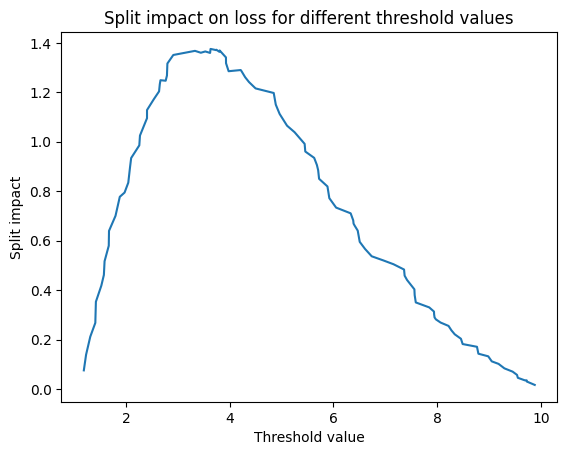

In [3]:
f_0 = 0.5 # initial prediction using zero as the initial prediction
x_opt = 0.0 # optimal threshold value

#Compute gradient and hessian of each sample
df["g"] = 2*(df["y"]-f_0)/len(df["y"])  # is this correct?
df["h"] = -2/len(df["y"])               # is this correct?


df = df.sort_values(by=['X'])
df.reset_index(inplace = True, drop = True)
#df.reset_index(inplace = True, drop = True) # We are not using the index anymore

#Keep track of the loss
l = [] 

#Test the different threshold, this is to find the optimal threshold to split the data
# Each threshold will be tested on the whole dataset
for i in range(len(df)):
    opt_split = np.inf
    # select the threshold to split the data
    t = df["X"][i]
    df_L =  df[df["X"]<t]
    df_R =  df[df["X"]>=t]
    
    G, H =np.sum(df["g"]), np.sum(df["h"])
    
    G_L = np.sum(df_L["g"])
    G_R = np.sum(df_R["g"])
    
    H_L = np.sum(df_L["h"])
    H_R = np.sum(df_R["h"])
    
    if (H==0) or (H_R==0) or (H_L ==0):
        continue
    
    # Compute the contribution of the split to the loss
    # check the XG Boost paper for the formula
    split = -1/2*((G_L**2)/H_L + (G_R**2)/H_R - (G**2)/H)
    
    l.append(split)
    
    opt_split = max(opt_split, split)
    
    if split == opt_split:
        x_opt = df["X"][i]

print(f'The optimal threshold value of {x_opt:.4}')
plt.plot(df["X"][1:],l)
plt.title("Split impact on loss for different threshold values")
plt.xlabel("Threshold value")
plt.ylabel("Split impact")

In [4]:

#Compute the new leaf weights
def split(df, x_opt):
    
    # split the data into two parts
    df_left  = df[df["X"]<x_opt]
    df_right = df[df["X"]>x_opt]
    # compute the gradient and hessian for each part
    G_Left = np.sum(df_left["g"])
    H_Left = np.sum(df_left["h"])
    
    G_Right = np.sum(df_right["g"])
    H_Right = np.sum(df_right["h"])

    w_left = -G_Left/H_Left
    w_right = -G_Right/H_Right
    
    return w_left, w_right

w_left, w_right = split(df, x_opt)

print(f'The optimal weight for the left leaf is {w_left:.4}')
print(f'The optimal weight for the right leaf is {w_right:.4}')

The optimal weight for the left leaf is nan
The optimal weight for the right leaf is 3.443


C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\1754259442.py:14: RuntimeWarning: invalid value encountered in double_scalars
  w_left = -G_Left/H_Left


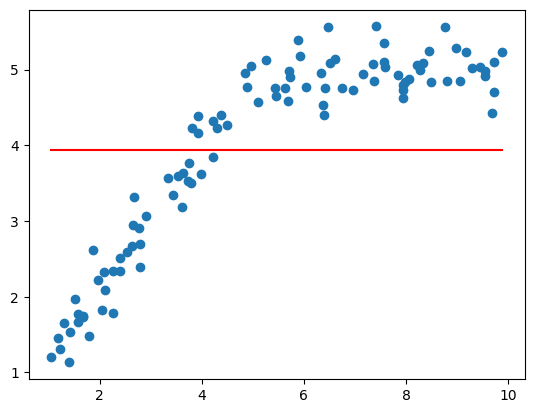

In [5]:
f_1 = []

for i in df["X"]: 
    if i<x_opt:
        f_1.append(f_0 + w_left)
    else :
        f_1.append(f_0 + w_right)

plt.figure()
plt.scatter(df["X"],df["y"])
plt.plot(df["X"],f_1, color = "red")

In [6]:

def generate_histograms(X, y, y_pred , n_bins = 10):
        """Generate the histogram representation of the data
        
        Returns:
        client_df: The dataframe of the client data with the gradient and hessian
        histograms: The histogram representation of the data per feature
                    histograms[i] = histogram of feature i. Each histogram is a dataframe with the following columns:
                                    "feature": the feature name
                                    "gradient": the gradient of the objective function for the feature
                                    "hessian": the hessian of the objective function for the feature
                                    "bin": the bin of the histogram
                                    the histogram for regression is the sum of the gradient and hessian
        """        
        
        ## Check if I need the y output if I already have the gradient and hessian
        client_df = pd.DataFrame(X)
        client_df["gradient"] = -2*(y.reshape(-1,1) - y_pred.reshape(-1,1))/ len(y)
        client_df["hessian"]  = 2/ len(y)
        
        # Must be a histogram for each feature
        histograms = [None]*(client_df.shape[1]-2)
        
        for i, feature in enumerate(client_df.columns):
            # skip the gradient and hessian
            if feature == "gradient" or feature == "hessian":
                continue
            # get the histogram of the feature and the gradient and hessian
            hist = client_df[[feature, "gradient", "hessian"]].copy()
            hist["bin"] = pd.qcut(client_df[feature], n_bins, duplicates = "drop") # check if should drop duplicates
            feat1 = hist.groupby("bin").agg({"gradient": "sum", "hessian": "sum"})
            feat1["bin"] = feat1.index.map(lambda x: x.mid).astype(float)
            histograms[i] = feat1.reset_index(drop = True)
            del hist # delete the hist dataframe to save memory
            
        return client_df, histograms

In [7]:
X = df["X"].values.reshape(-1,1)
y = df["y"].values.reshape(-1,1)
y_pred = y.mean()*0
n_bins = 30
client_df, histograms = generate_histograms(X, y, y_pred , n_bins)
#feat1 = histograms[0].groupby("bin").agg({"gradient": "sum", "hessian": "sum"})
#feat1["bin"] = feat1.index.map(lambda x: x.mid).astype(float)
#feat1.reset_index(inplace = True, drop = True)
feat1 = histograms[0]
histograms[0]


,gradient,hessian,bin
0,-0.112606,0.08,1.1940
1,-0.092732,0.06,1.4455
2,-0.103356,0.06,1.6115
3,-0.161277,0.08,1.8280
4,-0.124788,0.06,2.0810
5,-0.132618,0.06,2.2905
6,-0.210643,0.08,2.5280
7,-0.172381,0.06,2.7220
8,-0.186512,0.06,3.1000
9,-0.275100,0.08,3.5185


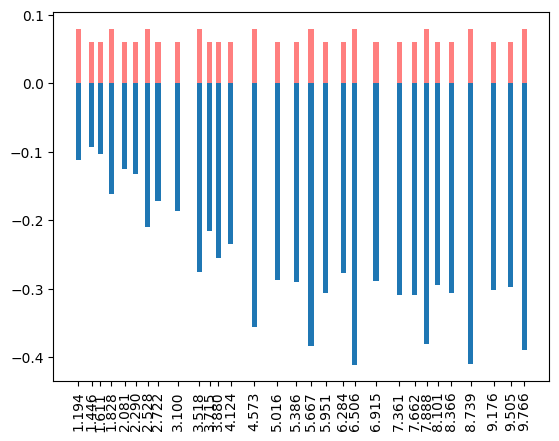

In [8]:
plt.bar(feat1["bin"], feat1["gradient"], width = 0.1)
plt.bar(feat1["bin"], feat1["hessian"], width = 0.1, color = "red", alpha = 0.5)
plt.xticks(feat1["bin"], rotation = 90)
plt.show()
plt.close()

In [9]:
def get_split_value_one_feature(histogram, lambda_ = 0.1, gamma = 0.1):
    """Compute the split value for a feature histogram
    
    Returns:
    score: the score for each bin
    split_value: the split value
    w_left: the weight for the left part of the histogram
    w_right: the weight for the right part of the histogram
    """
    # Initialize the score for each bin
    
    score = [None]*len(histogram)
    # Compute the total gradient and hessian
    g = histogram["gradient"].sum()
    h = histogram["hessian"].sum()
    # Compute the score for each bin
    
    for i, bin_ in enumerate(histogram["bin"]):
        if i == 0:
            score[i] = 0
            continue
        # Gets the gradient and hessian for the left and right part of the histogram (wheights)
        g_left = histogram["gradient"][:i].sum()
        h_left = histogram["hessian"][:i].sum()
        
        g_right = histogram["gradient"][i:].sum()
        h_right = histogram["hessian"][i:].sum()
        
        # Compute the score for left and right part of the histogram
        score[i] = (g_left**2/(h_left + lambda_) + g_right**2/(h_right + lambda_) - g**2/(h + lambda_))*0.5 - gamma
    
    # Get the split value and the index of the split
    split_value = histogram["bin"][np.argmax(score)]
    index_split = score.index(max(score))
    # Compute the weights for the left and right part of the histogram
    w_left = -histogram["gradient"][:index_split].sum()/(histogram["hessian"][:index_split].sum() + lambda_)
    w_right = -histogram["gradient"][index_split:].sum()/(histogram["hessian"][index_split:].sum() + lambda_)
    
    return score , split_value, w_left, w_right


## first it will be symmetric, then I will add the missing values
# The histogram should be already built for each feature, it includes the gradient and hessian
def build_tree(trees, histograms, lambda_ = 0.1, gamma = 0.1, max_depth = 2, max_leaves = 4, feature = 0):
    
    depth = 0
    leaves = 0 
    node = 0
    # Is the list of trees empty?
    if len(trees["tree_n"]) == 0:
        new_tree = 0
    else:
        new_tree = trees["tree_n"].max() + 1
        
    # Initialize the node counter
    
    # Do a first split for the root node
    # TODO: select the feature with the highest gain 
    #feature = np.random.choice(len(X_hist))
    # ID tree-0 ROOT NODE
    ID = str(new_tree) + "-" + str(node) 
    score , split_value, _, _ = get_split_value_one_feature(histograms[feature], lambda_ , gamma)
    # Add the root node to the tree
    node += 1
    yes = str(new_tree) + "-" + str(node) # takes the left values of the split 
    node += 1
    no  = str(new_tree) + "-" + str(node)
    # Compute the gain for the split
    gain = -histograms[feature]["gradient"].sum()**2/(histograms[feature]["hessian"].sum() + lambda_) 
    #missing = str(new_tree) + "-" + str(node + 3)
    
    new = pd.DataFrame({"tree_n": new_tree,
                        "node_n": node-2,
                        "feature": feature,
                        "ID": ID,
                        "depth": depth,
                        "split_value": split_value,
                        "yes": yes,
                        "no": no,
                        "missing": None,
                        "gain_w": gain}, index = [0])
    trees = trees.append(new, ignore_index = True)
    depth += 1
    leaves += 2
    splits = [split_value]
##############################################################################################
    # split the data into two parts
    hist_left  = histograms[feature][histograms[feature]["bin"] <= split_value]
    hist_right = histograms[feature][histograms[feature]["bin"] >  split_value].reset_index(drop = True)
    # Get the score for the left node
    score, split_value_l, wl_left, wl_right = get_split_value_one_feature(hist_left , lambda_ , gamma)
    score, split_value_r, wr_left, wr_right = get_split_value_one_feature(hist_right, lambda_ , gamma)
    # Left node
    ID = yes
    node += 1
    ID_left = str(new_tree) + "-" + str(node)
    node += 1
    ID_right = str(new_tree) + "-" + str(node)
    gain = -hist_left["gradient"].sum()**2/(hist_left["hessian"].sum() + lambda_)
    new = pd.DataFrame({"tree_n": new_tree,
                        "node_n": yes[-1],
                        "feature": feature,
                        "ID": ID,
                        "depth": depth,
                        "split_value": split_value_l,
                        "yes": ID_left,
                        "no": ID_right,
                        "missing": None,
                        "gain_w": gain}, index = [0])
    trees = trees.append(new, ignore_index = True)
    # Left leaf
    new = pd.DataFrame({"tree_n": new_tree,
                        "node_n": ID_left[-1],
                        "feature": "Leaf",
                        "ID": ID_left,
                        "depth": depth+1,
                        "split_value": split_value_l,
                        "yes": None,
                        "no": None,
                        "missing": None,
                        "gain_w": wl_left}, index = [0])
    trees = trees.append(new, ignore_index = True)
    # Right leaf
    new = pd.DataFrame({"tree_n": new_tree,
                        "node_n": ID_right[-1],
                        "feature": "Leaf",
                        "ID": ID_right,
                        "depth": depth+1,
                        "split_value": split_value_l,
                        "yes": None,
                        "no": None,
                        "missing": None,
                        "gain_w": wl_right}, index = [0])
    trees = trees.append(new, ignore_index = True)
    
    
    # Right node
    ID = no
    node += 1
    ID_left = str(new_tree) + "-" + str(node)
    node += 1
    ID_right = str(new_tree) + "-" + str(node)
    gain = -hist_right["gradient"].sum()**2/(hist_right["hessian"].sum() + lambda_)
    new = pd.DataFrame({"tree_n": new_tree,
                        "node_n": no[-1],
                        "feature": feature,
                        "ID": ID,
                        "depth": depth,
                        "split_value": split_value_r,
                        "yes": ID_left,
                        "no": ID_right,
                        "missing": None,
                        "gain_w": gain}, index = [0])
    trees = trees.append(new, ignore_index = True)
    # Left leaf
    new = pd.DataFrame({"tree_n": new_tree,
                        "node_n": ID_left[-1],
                        "feature": "Leaf",
                        "ID": ID_left,
                        "depth": depth+1,
                        "split_value": None,
                        "yes": None,
                        "no": None,
                        "missing": None,
                        "gain_w": wr_left}, index = [0])
    trees = trees.append(new, ignore_index = True)
    # Right leaf
    new = pd.DataFrame({"tree_n": new_tree,
                        "node_n":ID_right[-1],
                        "feature": "Leaf",
                        "ID": ID_right,
                        "depth": depth+1,
                        "split_value": None,
                        "yes": None,
                        "no": None,
                        "missing": None,
                        "gain_w": wr_right}, index = [0])
    trees = trees.append(new, ignore_index = True)
              
    return trees

def predict_tree(tree, X, y_init ):
    """Predict the target value for a given tree
    """
    x = X.values.reshape(-1,1)
    i = 0 # start at the root node
    feature = tree["feature"].values[i]
    
    while True:
        
        if tree["feature"].values[i] == "Leaf":
            return y_init + tree["gain_w"].values[i]
        
        elif x[feature] <= tree["split_value"].values[i]:
            i = tree[tree["ID"] == tree["yes"].values[i]].index[0]

        elif x[feature] > tree["split_value"].values[i]:
            i = tree[tree["ID"] == tree["no"].values[i]].index[0]
            

def built_ensamble(histograms, nuber_of_trees, lambda_ = 0.1, gamma = 0.1, max_depth = 2, max_leaves = 4, feature = 0, trees = None):
    """Build an ensamble of trees
    """
    if trees is None:
        print("No trees")
        print("Initilize the tree dataframe")
        print("trees = pd.DataFrame(columns = ['tree_n', 'node_n' ,'feature', 'ID', 'depth', 'split_value', 'yes', 'no', 'missing', 'gain_w'])")
        return None
    
    for i in range(nuber_of_trees):
        trees = build_tree(trees, histograms, lambda_ , gamma, max_depth, max_leaves, feature)
    return trees

def predict_esnamble(trees, X, y_init=0):
    """Predict the target value for a given ensamble of trees
        y_init: the initial prediction of the target, which is always 0 in this case 
    """
    y_pred = y_init
    
    for i in range(trees["tree_n"].max() ):
        tree = trees[trees["tree_n"] == i].copy().reset_index(drop = True)
        y_pred = predict_tree(tree, X, y_pred)

    return y_pred


1.3453940878034754

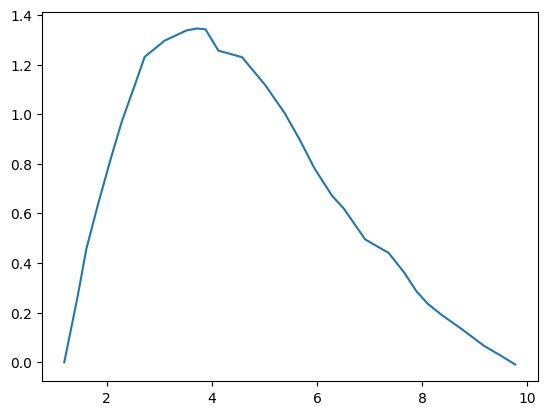

In [10]:
lambda_ = 0.004
gamma = 0
score , split_value, w_left, w_right = get_split_value_one_feature(feat1, lambda_, gamma)
plt.plot(feat1["bin"], score)
w_left, w_right
max(score)

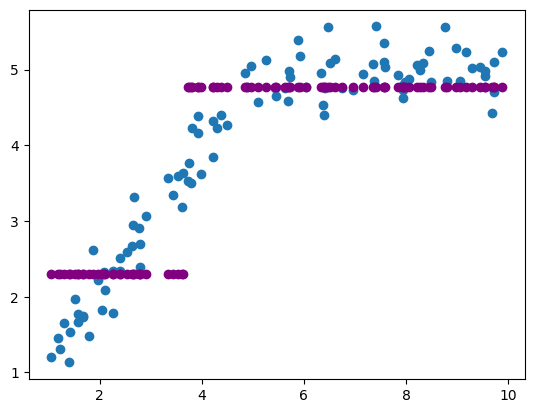

In [11]:
predictions = y_pred + [w_left if i<split_value else w_right for i in df["X"]]
plt.figure()
plt.scatter(df["X"],df["y"])
plt.scatter(df["X"],predictions, color = "purple")

next_hist1 = feat1.where(feat1["bin"]>split_value).dropna()
next_hist2 = feat1.where(feat1["bin"]<=split_value).dropna()


In [12]:
trees = pd.DataFrame(columns = ["tree_n", "node_n", "feature", "ID", "depth", "split_value", "yes", "no", "missing", "gain_w"])
trees = build_tree(trees, histograms, lambda_ , gamma , max_depth = 2, max_leaves = 4, feature = 0)

C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\3553116636.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\3553116636.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\3553116636.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\3553116636.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = Tru

In [13]:
X = df["X"]
X = pd.DataFrame(X)
X.shape
x1 = X.iloc[0]
x1.values

array([1.04969905])

In [14]:
trees = pd.DataFrame(columns = ["tree_n", "node_n" ,"feature", "ID", "depth", "split_value", "yes", "no", "missing", "gain_w"])
trees = built_ensamble(histograms, 1, lambda_ , gamma , max_depth = 2, max_leaves = 4, feature = 0, trees = trees)

C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\3553116636.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\3553116636.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\3553116636.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\3553116636.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = Tru

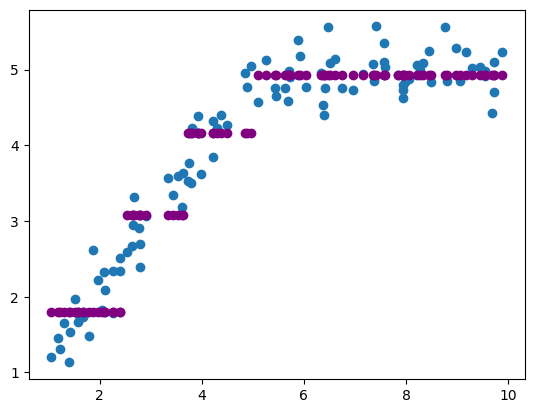

In [15]:
y_predict = [predict_tree(trees,X.iloc[i] , y_init = 0) for i in range(len(X))]
plt.scatter(df["X"],df["y"])
plt.scatter(df["X"],y_predict, color = "purple")

In [16]:
y_predict = np.array(y_predict)
client_df, histograms = generate_histograms(df["X"].values, df["y"].values,y_predict, n_bins )

<BarContainer object of 30 artists>

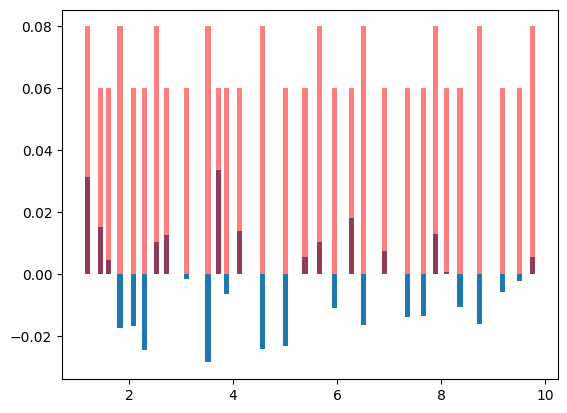

In [17]:
plt.bar(histograms[0]["bin"], histograms[0]["gradient"], width = 0.1)
plt.bar(histograms[0]["bin"], histograms[0]["hessian"], width = 0.1, color = "red", alpha = 0.5)

C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\3553116636.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\3553116636.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\3553116636.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\3553116636.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = Tru

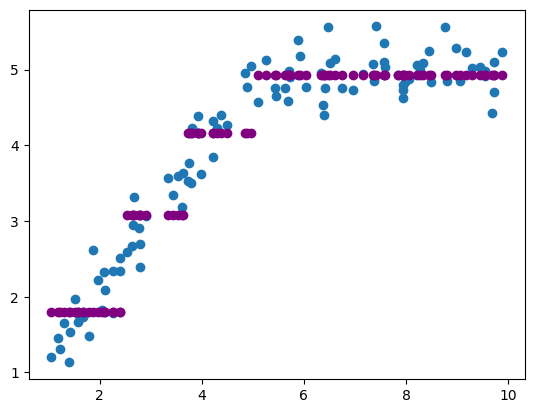

In [18]:
tree2 = build_tree(trees, histograms, lambda_ , gamma, max_depth = 2, max_leaves = 4, feature = 0)
y_predict = [predict_esnamble(tree2, X.iloc[i], y_init = 0) for i in range(len(X))]
plt.scatter(df["X"],df["y"])
plt.scatter(df["X"],y_predict, color = "purple")

C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\3553116636.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\3553116636.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\3553116636.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\3553116636.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = Tru

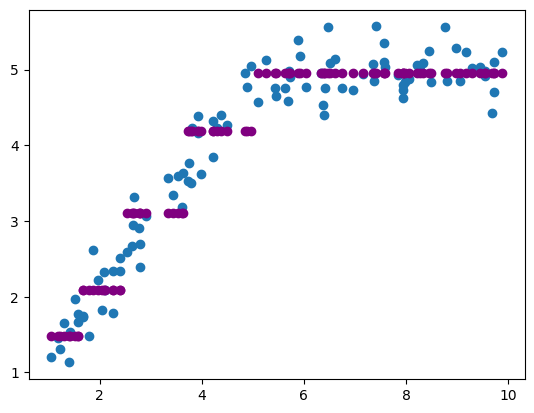

In [19]:
tree3 = build_tree(tree2, histograms, lambda_ , gamma , max_depth = 2, max_leaves = 4, feature = 0)
y_predict = [predict_esnamble(tree3, X.iloc[i], y_init = 0) for i in range(len(X))]
plt.scatter(df["X"],df["y"])
plt.scatter(df["X"],y_predict, color = "purple")

In [20]:
def built_ensamble_w_dataset(X, y, nuber_of_trees, lambda_ = 0.1, gamma = 0.1, max_depth = 2, max_leaves = 4, feature = None, trees = None, n_bins = 25):
    """Build an ensamble of trees
    """
    if trees is None:
        print("No trees")
        print("Initilize the tree dataframe")
        print("trees = pd.DataFrame(columns = ['tree_n', 'node_n' ,'feature', 'ID', 'depth', 'split_value', 'yes', 'no', 'missing', 'gain_w'])")
        return None
    y_init = 0
    opt_split = np.inf
    
    # Here I start the loop to create the trees in number of trees test feature importance 
    for i in range(nuber_of_trees):
        
        # Predict the target value for the ensamble
        if i == 0:
            y_pred = y_init*np.zeros(len(y))
        else:
            y_pred = np.array([predict_tree(trees,X.iloc[i] , y_init = 0) for i in range(len(X))])
            
        _, histograms = generate_histograms(X, y, y_pred , n_bins )
        
        ### Here the feature selection is performed ###
        ##  The feature is selected based on the variance of the target value prediction (variance reduction)
        if feature is None:
            for feat in range(len(histograms)):
                
                dummy_tree = build_tree(trees, histograms, lambda_ , gamma, max_depth, max_leaves, feat)
                y_pred = np.array([predict_tree(dummy_tree,X.iloc[i] , y_init = 0) for i in range(len(X))])
                var = np.std(y - y_pred)**2
               
                if var < opt_split:
                    opt_split = var
                    feature = feat
                   
                    
        # Generate new tree and add it to the ensamble   
        trees = build_tree(trees, histograms, lambda_ , gamma, max_depth, max_leaves, feature)
        
    return trees, y_init


# Function to predict the target value for a given ensamble of trees
def Pred_trees(trees, X, y_init):
    y_predict = [predict_esnamble(trees, X.iloc[i], y_init ) for i in range(len(X))]
    y_predict = np.array(y_predict)
    return y_predict


def RMSE(y, y_pred):
    return np.sqrt(np.mean((y - y_pred)**2))

In [21]:
gamma = 0.000
lambda_ = 0.00
trees_test = pd.DataFrame(columns = ['tree_n', 'node_n' ,'feature', 'ID', 'depth', 'split_value', 'yes', 'no', 'missing', 'gain_w'])
trees, y_init = built_ensamble_w_dataset(X, y, 8 , lambda_, gamma, max_depth = 2, max_leaves = 4, feature = None, trees = trees_test, n_bins = 30)

C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\3553116636.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\3553116636.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\3553116636.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\3553116636.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = Tru

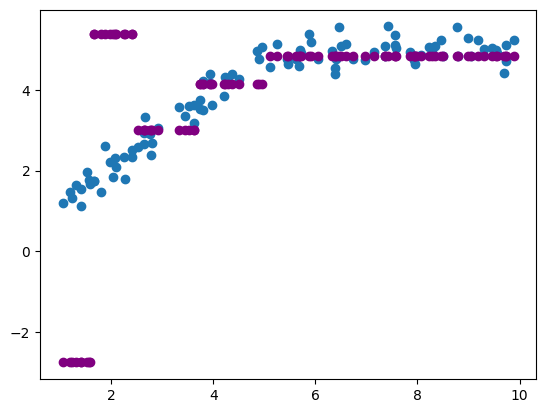

In [22]:
trees.head(10)
y_predict = Pred_trees(trees, X, 0)
plt.scatter(df["X"],df["y"])
plt.scatter(df["X"], y_predict, color = "purple")

## Testing the trees in PVdata, the comparisson is the XGBOOST model Library

In [23]:
#TODO: TRY WITH FEATURES 0, 3 and 4 FROM the pv dataset and compare with the XGBoost results. 

import pickle, os, sys, math
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import random
import matplotlib.pyplot as plt

PROJECT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(1, PROJECT_DIR)

from samples.data_sim import remove_feature
from city_pv_uni_modal import CityPV_UniModal
from city_pv_multi_modal import CityPV_MultiModal
from feature_selection import tune_pacf, rfecv_selection
from utils_pv import get_available_modules, get_available_inverters, visualize_pv, visualize_env, adj_r2_scorer
from samples.data_sim import PVDataset

random_seed = 3
random.seed(random_seed)
np.random.seed(random_seed)
random_state = np.random.RandomState(random_seed)


# Name of the experiment
exp_name = 'PV_UniModal'

def open_experiment(exp_name):
    filename_env = os.getcwd() + '/../../saved_results/' + exp_name + '_env' 
    file = open(filename_env + '_feat_eng', 'rb')
    env_dict = pickle.load(file)
    file.close()
    return env_dict

env_dict = open_experiment(exp_name)


#msg = '[INFO] loaded data for {:2.0f} clients'.format(env_dict['num_clients']) no need to store msg in a variable
#print('\n'+env_dict['info'])
print(f"[INFO] loaded data for {env_dict['num_clients']:2.0f} clients' \n\n{env_dict['info']}")

for scenario_name in env_dict['train_scenarios'].keys():
    print(scenario_name + ' has {:3.0f} train and {:3.0f} validation samples'.format(
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][0].shape[0],
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][2].shape[0]))
print('number of features = {:2.0f}'.format(
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][0].shape[1]))
print(f"Features:{env_dict['feature_names']}")

# for client 1
# get normalized training and validation data
from utils_pv import normalize_data_tup

# normalizing the data with 150 training samples
scenario_name = '1y'
clients_data = env_dict['train_scenarios'][scenario_name]['clients_data']
clients_data_nrm = [None]*len(clients_data)
for client_num in np.arange(env_dict['num_clients']):
    clients_data_nrm[client_num], _, _ = normalize_data_tup(clients_data[client_num])

client_num = 0  # fit for the house number 0
x_train_nrm, y_train_nrm, x_valid_nrm, y_valid_nrm = clients_data_nrm[client_num]
client_num_1 = 8  # fit for the house number 0
x_train_nrm_1, y_train_nrm_1, x_valid_nrm_1, y_valid_nrm_1 = clients_data_nrm[client_num_1]
client_num_2 = 10  # fit for the house number 0
x_train_nrm_2, y_train_nrm_2, x_valid_nrm_2, y_valid_nrm_2 = clients_data_nrm[client_num_2]

[INFO] loaded data for 24 clients' 

24 households at Lausanne - tilt_std: 5.0, az_std: 15.0, weather_dev: 0.1, irrad_std: 0.2, altitude_dev: 0.1, shadow_peak_red: 0.8, different module_name, different inverter_name, 
sml has 150 train and 610 validation samples
1y has 610 train and 610 validation samples
5y has 3050 train and 610 validation samples
14y has 8540 train and 610 validation samples
number of features = 22
Features:['H_sun', 'T2m', 'WS10m', 'station_irrad_direct_prev', 'lag 1', 'lag 2', 'lag 3', 'lag 4', 'lag 18', 'lag 20', 'lag 21', 'lag 22', 'lag 43', 'lag 44', 'lag 69', 'lag 70', 'lag 72', 'lag 74', 'lag 121', 'lag 145', 'lag 169', 'lag 190']


In [24]:

Xdf = pd.DataFrame(x_train_nrm)
Ydf = pd.DataFrame(y_train_nrm).values
gamma = 0.00
lambda_ = 0.005

In [25]:
# Build the histogram for each feature
# Initialize the ensamble of trees
trees_test_pv = pd.DataFrame(columns = ['tree_n', 'node_n' ,'feature', 'ID', 'depth', 'split_value', 'yes', 'no', 'missing', 'gain_w'])
# Build the ensamble of trees with the training dataset
trees_pv, y_init = built_ensamble_w_dataset(Xdf, Ydf, 50, lambda_ , gamma, max_depth = 2, max_leaves = 4, feature=None, trees = trees_test, n_bins = 300)

C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\3553116636.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\3553116636.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\3553116636.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\3553116636.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = Tru

3.4676935551404013

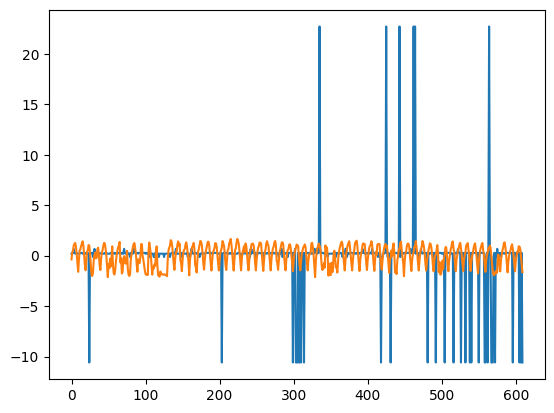

In [26]:
# Predict the target value for the training dataset
y_predict = Pred_trees(trees_pv, Xdf, y_init=0)
plt.plot(y_predict)
plt.plot(Ydf)
RMSE(y_predict, Ydf)

### Test with trainig based on feature importance of the result with the library. Just for comparisson purposes.

In [27]:

trees_pv, _ = built_ensamble_w_dataset(Xdf, Ydf, 1, lambda_ , gamma , max_depth = 2, max_leaves = 3, feature = 3, trees = trees_pv, n_bins = 250)
trees_pv, _ = built_ensamble_w_dataset(Xdf, Ydf, 1, lambda_ , gamma , max_depth = 2, max_leaves = 4, feature = 4, trees = trees_pv, n_bins = 250)
trees_pv, _ = built_ensamble_w_dataset(Xdf, Ydf, 1, lambda_ , gamma , max_depth = 2, max_leaves = 4, feature = 12, trees = trees_pv, n_bins = 250)
trees_pv, _ = built_ensamble_w_dataset(Xdf, Ydf, 1, lambda_ , gamma , max_depth = 2, max_leaves = 4, feature = 4, trees = trees_pv, n_bins = 250)
trees_pv, _ = built_ensamble_w_dataset(Xdf, Ydf, 1, lambda_ , gamma , max_depth = 2, max_leaves = 4, feature = 4, trees = trees_pv, n_bins = 250)
trees_pv, _ = built_ensamble_w_dataset(Xdf, Ydf, 1, lambda_ , gamma , max_depth = 2, max_leaves = 4, feature = 0, trees = trees_pv, n_bins = 250)

C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\3553116636.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\3553116636.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\3553116636.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\3553116636.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = Tru

3.182099534202365

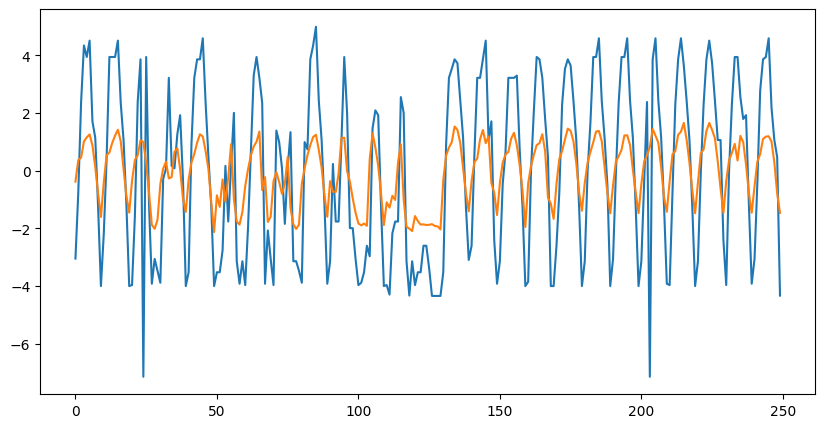

In [28]:
Y_reduced = Ydf[0:250]
X_reduced = Xdf[0:250]
y_predict = Pred_trees(trees_pv, X_reduced, y_init=0)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(y_predict)
ax.plot(Y_reduced)
RMSE(y_predict, Y_reduced)

A toy example of the aggregation and Federated learning with XGBOOST

In [29]:
### train with a new histogram

"""Pseudocode for the aggregator"""
""" Agreggator sends the model "trees_pv" to the clients"""


"""The Clients receive the model "trees_pv" and with their data they compute the prediction "y_pred" """
# each client computes the prediction with the model "trees_pv", compute the histogram and sends it to the aggregator
Xdf = pd.DataFrame(x_train_nrm_1)
Ydf = pd.DataFrame(y_train_nrm_1).values
gamma = 0.00
lambda_ = 0.005

y_pred = Pred_trees(trees_pv, Xdf, y_init=0)

client_df, histograms = generate_histograms(Xdf, Ydf,y_pred , n_bins = 300)


C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\3553116636.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\3553116636.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\3553116636.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = True)
C:\Users\hecma\AppData\Local\Temp\ipykernel_11900\3553116636.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trees = trees.append(new, ignore_index = Tru

3.746653274297918

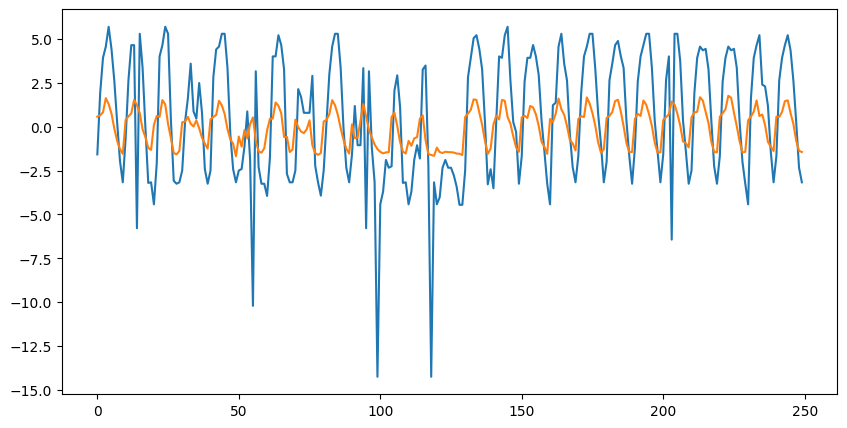

In [30]:

"""Now here just for the sake of the example we will use the same data to build the tree, 
but in reality the clients will send the histograms to the aggregator
the aggregator merges the histograms of all clients and  will build the tree"""

# New tree is built with ONLY the histograms
trees_pv = build_tree(trees_pv,histograms,lambda_,gamma, max_depth = 2, max_leaves = 4, feature=4)


# New predictions with updated model "trees_pv"
Y_reduced = Ydf[0:250]
X_reduced = Xdf[0:250]
y_predict = Pred_trees(trees_pv, X_reduced, y_init=0)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(y_predict)
ax.plot(Y_reduced)


RMSE(y_predict, Y_reduced)